In [1]:
import torch
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch import nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import random

2.2.1+cu121


In [2]:
df = pd.read_csv('../fyp_data/smooth_df.csv')

date_column = 'Date'
date_number_column = 'Date Number'
ili_rate_column = 'ILI Rate'
query_columns = [col for col in df.columns if col not in [date_column, date_number_column, ili_rate_column]]

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [3]:
def custom_time_series_split(df, date_column):
    # Custom time series split based on years
    years = df[date_column].dt.year.unique()
    splits = [(years[5], years[i]) for i in range(10, len(years) - 4)]
    return splits

def get_train_test_split_data(X_shifted, y_shifted, X, y, train_start_date, test_start_date, test_end_date, corr_start_date):
    # Get the training and test data for a specific split
    train_indices = (X_shifted[date_column] >= train_start_date) & (X_shifted[date_column] < test_start_date)
    test_indices = (X_shifted[date_column] >= test_start_date) & (X_shifted[date_column] <= test_end_date)
    corr_indices = (X[date_column] >= corr_start_date) & (X[date_column] < test_start_date)

    X_train, y_train = X_shifted[train_indices], y_shifted[train_indices]
    X_test, y_test = X_shifted[test_indices], y_shifted[test_indices]
    X_corr, y_corr = X[corr_indices], y[corr_indices]

    return (X_train.iloc[:, 1:], y_train, X_test.iloc[:, 1:], y_test, X_corr.iloc[:, 1:], y_corr)

def min_max_data(X_train, X_test):
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    return X_train_scaled, X_test_scaled

def create_lagged_features(df, n_lags):
    lagged_dfs = [df]
    for lag in range(1, n_lags + 1):
        lagged_df = df.shift(lag)
        lagged_df = lagged_df.add_suffix(f'_t-{lag}')
        lagged_dfs.append(lagged_df)

    all_lagged_df = pd.concat(lagged_dfs, axis=1)
    all_lagged_df = all_lagged_df.dropna()
    return all_lagged_df

def create_lagged_features_with_overlap(X_train, y_train, X_test, n_lags=13):
    X_train_lagged = create_lagged_features(X_train, n_lags)
    y_train = y_train.iloc[n_lags:]

    X_test = pd.concat([X_train.iloc[-n_lags:], X_test], ignore_index=True)
    X_test_lagged = create_lagged_features(X_test, n_lags)

    return X_train_lagged.values, y_train, X_test_lagged.values

def convert_to_tensor(X_train, y_train, X_test, y_test):
    return (
        torch.FloatTensor(X_train), torch.FloatTensor(y_train.values), torch.FloatTensor(X_test), torch.FloatTensor(y_test.values)
    )

In [4]:
def get_correlation_df(X_corr, y_corr):
    correlation_scores = []
    for query_column in X_corr.columns:
        correlation = y_corr.corr(X_corr[query_column])
        correlation_scores.append((query_column, correlation))
    return pd.DataFrame(correlation_scores, columns=['Query', 'Correlation'])

def correlation_based_feature_selection(X_corr, y_corr, X_train, X_test, threshold):
    correlation_df = get_correlation_df(X_corr, y_corr).sort_values(by='Correlation', ascending=False).reset_index(drop=True)
    relevant_queries = correlation_df[correlation_df['Correlation'] >= threshold]['Query'].to_list()

    X_train = X_train[relevant_queries]
    X_test = X_test[relevant_queries]

    print("number of features after correlation based fs: ", X_train.shape[1])
    print("X_train: ", X_train.shape, "X_test: ", X_test.shape)

    return X_train, X_test

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 4)
        self.fc2 = nn.Linear(4, 1)
        self.dropout = nn.Dropout(0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def create_ffnn(X_train, seed):
    torch.manual_seed(seed)
    return SimpleNN(X_train.shape[1]).to(device)

In [6]:
def train_neural_network(model, X_train, y_train, X_test, y_test, test_start_year, epochs=200, learning_rate=0.001, patience=15):
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=14, shuffle=False)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=14, shuffle=False)

    best_val_loss = float('inf')
    patience_counter = 0

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, targets)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader))

        # Test phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs).squeeze(1)
                test_loss += criterion(outputs, targets).item()
            test_loss /= len(test_loader)
            test_losses.append(test_loss)

    # plt.figure(figsize=(10, 6))
    # plt.plot(train_losses, label='Training Loss')
    # plt.plot(test_losses, label='Test Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.title(f'Training and Validation Losses {test_start_year}-{test_start_year+1}')
    # plt.legend()
    # plt.show()

    return (model, epoch+1, train_losses, test_losses)


def evaluate_neural_network(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        X_test = X_test.to(device)
        y_test = y_test.to(device)

        y_pred = model(X_test)


        y_pred_cpu = y_pred.cpu().detach().numpy().flatten()
        y_test_cpu = y_test.cpu().numpy().flatten()

        print("y_pred: ", y_pred_cpu[0:5])

        mae = mean_absolute_error(y_test_cpu, y_pred_cpu)
        mape = np.mean(np.abs((y_test_cpu - y_pred_cpu) / y_test_cpu)) * 100
        pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)
        print("MAE: ", mae, "MAPE: ", mape, "P: ", pearson_corr)

    return y_pred_cpu, mae, mape, pearson_corr

In [7]:
def add_average_row(model_performance):
    mae_avg = np.mean(model_performance['MAE'])
    pearson_corr_avg = np.mean(model_performance['Pearson_Correlation'])
    mape_avg = np.mean(model_performance['MAPE'])
    print("MAE AVG: ", mae_avg, "MAPE AVG: ", mape_avg, "P AVG: ", pearson_corr_avg, "\n\n")

    model_performance.loc[len(model_performance)] = {
        'Year': 'Average',
        'MAE': mae_avg,
        'MAPE': mape_avg,
        'Pearson_Correlation': pearson_corr_avg
    }

def run_neural_network(queries, threshold):
    X = df[[date_column] + queries]
    y = df[ili_rate_column]

    forecasting_horizon = 14
    y_shifted = y.shift(-forecasting_horizon)
    y_shifted = y_shifted.iloc[:-forecasting_horizon]
    X_shifted = X.iloc[:-forecasting_horizon]

    splits = custom_time_series_split(df, date_column)
    
    seed_train_losses = {}
    seed_test_losses = {}

    seed_performances = []
    seed_predictions = []

    seeds = [9904, 5727, 4644, 2955, 3021, 3094, 8349, 5566, 1564, 1723]

    for seed in seeds:
        print("SEED: ", seed)

        model_performance = pd.DataFrame(columns=['Year', 'MAE', 'MAPE', 'Pearson_Correlation'])
        model_predictions = pd.DataFrame(columns=['Date', 'Actual_ILI_Rate', 'Predicted_ILI_Rate'])

        for train_start_year, test_start_year in splits:
            if (test_start_year, test_start_year+1) not in seed_train_losses:
                seed_train_losses[(test_start_year, test_start_year+1)] = []
                seed_test_losses[(test_start_year, test_start_year+1)] = []

            train_start_date = f'{train_start_year}-09-01'
            test_start_date = f'{test_start_year}-09-01'
            test_end_date = f'{test_start_year+1}-08-31'
            corr_start_date = f'{test_start_year-5}-09-01'

            print("train_start_date: ", train_start_date, "test_start_date: ", test_start_date, "test_end_date: ", test_end_date)

            X_train, y_train, X_test, y_test, X_corr, y_corr = get_train_test_split_data(X_shifted, y_shifted, X, y, train_start_date, test_start_date, test_end_date, corr_start_date)
            X_train, X_test = correlation_based_feature_selection(X_corr, y_corr, X_train, X_test, threshold)
            X_train, X_test = min_max_data(X_train, X_test)
            # X_train, y_train, X_test = create_lagged_features_with_overlap(X_train, y_train, X_test)
            X_train, y_train, X_test, y_test = convert_to_tensor(X_train.values, y_train, X_test.values, y_test)

            model, epochs, train_losses, test_losses = train_neural_network(create_ffnn(X_train, seed), X_train, y_train, X_test, y_test, test_start_year)
            seed_train_losses[(test_start_year, test_start_year+1)].append(train_losses)
            seed_test_losses[(test_start_year, test_start_year+1)].append(test_losses)
            y_pred, mae, mape, pearson_corr = evaluate_neural_network(model, X_test, y_test)

            model_performance.loc[len(model_performance)] = {
                'Year': f'{test_start_year}-{test_start_year+1}',
                'MAE': mae,
                'MAPE': mape,
                'Pearson_Correlation': pearson_corr,
            }

            date_range = pd.date_range(start=f'{test_start_year}-09-{forecasting_horizon+1}', periods=len(y_pred))
            iteration_predictions = pd.DataFrame({
                'Date': date_range,
                'Predicted_ILI_Rate': y_pred,
                'Actual_ILI_Rate': y_test.cpu().numpy().flatten()
            })
            model_predictions = pd.concat([model_predictions, iteration_predictions])

        add_average_row(model_performance)

        seed_performances.append(model_performance)
        seed_predictions.append(model_predictions)

    avg_performance = pd.concat(seed_performances).groupby(['Year']).agg({'MAE': ['mean', 'std'], 'Pearson_Correlation': ['mean', 'std'], 'MAPE': ['mean', 'std']}).reset_index().round(5)
    avg_predictions = pd.concat(seed_predictions).groupby(['Date']).mean().reset_index()

    for test_start_year, test_end_year in seed_train_losses.keys():
        mean_train_losses = np.mean(np.array(seed_train_losses[(test_start_year, test_end_year)]), axis=0)
        mean_test_losses = np.mean(np.array(seed_test_losses[(test_start_year, test_end_year)]), axis=0)

        plt.figure(figsize=(10, 6))
        plt.plot(mean_train_losses, label='Training Loss')
        plt.plot(mean_test_losses, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Losses {test_start_year}-{test_start_year+1}')
        plt.legend()
        plt.show()

    return avg_performance, avg_predictions

SEED:  9904
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.744646  3.6191561 2.528577  3.1037366 3.1613884]
MAE:  1.7424712 MAPE:  26.326870918273926 P:  0.9068422340661537
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.2088919 2.1880417 2.723824  2.9293547 2.361891 ]
MAE:  1.8114767 MAPE:  21.691057085990906 P:  0.9232731406914206
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.1921475 2.6807137 2.1933842 1.7730693 2.2746613]
MAE:  2.5443895 MAPE:  61.20721697807312 P:  0.9165454765078364
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.3336318 2.195329  3.3598957 3.2667522 3.7085829]
MAE:  3.1124501 MAPE:  31.577369570732117 P:  0.9455980331466368
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.2624993 1.0038753 1.823704  1.9236655 3.279252 ]
MAE:  2.6661656 MAPE:  71.5588629245758 P:  0.8964133133309528
MAE AVG:  2.3753905 MAPE AVG:  42.472275495529175 P AVG:  0.9177344395486001 


SEED:  5727
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.4744399 3.7557359 2.4506083 2.974467  3.0462613]
MAE:  1.775659 MAPE:  27.291223406791687 P:  0.9038853605543884
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.973938  1.9968886 2.5701418 2.921207  2.1207998]
MAE:  1.8916146 MAPE:  24.589835107326508 P:  0.9177887079015973
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.295778  2.541035  2.3211515 1.8582894 2.450187 ]
MAE:  2.2469609 MAPE:  48.918625712394714 P:  0.9122278529794613
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.180107  2.3865905 2.6527586 2.8537393 2.8559341]
MAE:  3.1757445 MAPE:  24.33977574110031 P:  0.925550408211702
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [5.245599 5.245599 5.245599 5.245599 5.245599]
MAE:  4.4118724 MAPE:  109.01087522506714 P:  nan
MAE AVG:  2.7003703 MAPE AVG:  46.83006703853607 P AVG:  0.9148630824117873 


SEED:  4644
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)


/tmp/ipykernel_2532471/3281515322.py:69: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_test_cpu, y_pred_cpu)


y_pred:  [2.7920885 3.6235616 2.7622473 3.125177  3.173496 ]
MAE:  1.7394581 MAPE:  23.83280247449875 P:  0.8967436107002541
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.259495  2.2969587 2.6817892 2.8203382 2.4253042]
MAE:  1.7476072 MAPE:  18.882901966571808 P:  0.9275765732782402
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.4139032 2.421526  2.374805  2.111186  2.7118049]
MAE:  2.5561733 MAPE:  54.01073694229126 P:  0.8943954204482265
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.1079226 2.4336104 2.9357522 2.9617043 3.1006684]
MAE:  2.8622334 MAPE:  23.333990573883057 P:  0.9429428236339954
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.2582927 2.029391  2.0298278 2.0175161 2.1235657]
MAE:  1.881307 MAPE:  38.577476143836975 P:  0.9285723697449927
MAE AVG:  2.1573558 MAPE AVG:  31.72758162021637 P AVG:  0.9180461595611418 


SEED:  2955
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.9631262 3.531796  2.644327  3.145224  3.2828083]
MAE:  1.7049955 MAPE:  25.582826137542725 P:  0.9082403943629821
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.8197316 1.7807423 2.2841415 2.6174932 1.9821233]
MAE:  1.8873365 MAPE:  23.71489107608795 P:  0.921073811367303
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.1952896 2.4737768 2.3087075 1.9082558 2.4285471]
MAE:  2.1130233 MAPE:  45.52065432071686 P:  0.9106055761027081
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.9544809 2.2378297 2.7076294 2.7096753 2.8434281]
MAE:  3.0439503 MAPE:  26.39128267765045 P:  0.939172729408997
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.1746185 2.0621612 2.251927  2.3281453 2.6425211]
MAE:  1.6265063 MAPE:  35.93384623527527 P:  0.9283798888155647
MAE AVG:  2.0751624 MAPE AVG:  31.42870008945465 P AVG:  0.9214944800115109 


SEED:  3021
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.690601  3.603543  2.775621  2.977332  3.0044475]
MAE:  1.684193 MAPE:  22.568786144256592 P:  0.8986836843112346
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.3735783 2.4111848 2.9915192 3.096008  2.4222987]
MAE:  1.7913332 MAPE:  22.068265080451965 P:  0.9189363853775676
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.1725469 2.8645725 2.2904997 1.1791337 2.2702577]
MAE:  2.4224498 MAPE:  60.89194416999817 P:  0.9155287123531719
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.1377494 2.3945384 2.7977977 2.8424902 2.9647822]
MAE:  2.9125621 MAPE:  23.440685868263245 P:  0.9403326961314848
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.3365755 2.1012383 2.2201145 2.590649  3.0878553]
MAE:  1.9325963 MAPE:  44.38015520572662 P:  0.9318212113985395
MAE AVG:  2.1486268 MAPE AVG:  34.66996729373932 P AVG:  0.9210605379143997 


SEED:  3094
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.57404   3.8432064 2.5742574 3.0427842 3.1158404]
MAE:  1.7791826 MAPE:  26.997488737106323 P:  0.9046262638180099
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.1110368 2.1588507 2.7976446 3.0818758 2.171174 ]
MAE:  1.8919352 MAPE:  25.898417830467224 P:  0.9122347920142018
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.124177  2.8796227 2.3237085 1.1666265 2.2190003]
MAE:  2.3938053 MAPE:  60.42405962944031 P:  0.9154784313711654
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.1614181 2.0758061 3.2167895 3.1060052 3.5955193]
MAE:  3.3171272 MAPE:  36.21276319026947 P:  0.946232706491516
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.3951497  0.84061354 1.4098324  1.9834244  3.0132225 ]
MAE:  2.2750096 MAPE:  56.99324011802673 P:  0.9052641003164489
MAE AVG:  2.331412 MAPE AVG:  41.30519390106201 P AVG:  0.9167672588022684 


SEED:  8349
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.4086792 4.00689   2.557472  3.0245285 3.0861523]
MAE:  1.8362846 MAPE:  27.91435420513153 P:  0.899373146407832
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.4134026 2.4862783 3.0767722 3.1310287 2.487671 ]
MAE:  1.814516 MAPE:  22.977401316165924 P:  0.9140019398548771
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.099261  2.9318726 2.3407707 1.1749803 2.1878595]
MAE:  2.4400685 MAPE:  61.51740550994873 P:  0.9155901682064356
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.2919118 2.166093  3.33303   3.2445366 3.678709 ]
MAE:  3.1806073 MAPE:  34.630560874938965 P:  0.945270935147229
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.3665423 2.150274  2.1579807 2.0893114 2.185914 ]
MAE:  2.3025694 MAPE:  47.070351243019104 P:  0.9265540779906829
MAE AVG:  2.3148093 MAPE AVG:  38.82201462984085 P AVG:  0.9201580535214113 


SEED:  5566
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.9497192 3.5161085 2.5925741 3.1234958 3.2591803]
MAE:  1.7074202 MAPE:  25.640571117401123 P:  0.9083277113035557
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.8506241 1.8384151 2.3250408 2.6514823 2.0100465]
MAE:  1.8828577 MAPE:  23.58175814151764 P:  0.9213029691147563
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.4357653 2.4978995 2.4224784 2.1472394 2.694784 ]
MAE:  2.460577 MAPE:  52.60229706764221 P:  0.8920320690059174
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.7305013 2.1391973 2.8146856 2.7738092 3.0384653]
MAE:  3.0888672 MAPE:  25.607681274414062 P:  0.9461417931224798
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.4978781 0.7790035 1.301505  2.1569672 3.100631 ]
MAE:  2.2776372 MAPE:  55.99313974380493 P:  0.9058601947264614
MAE AVG:  2.2834718 MAPE AVG:  36.685089468955994 P AVG:  0.9147329474546341 


SEED:  1564
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.6598597 3.7674313 2.5546818 3.0370998 3.1307895]
MAE:  1.761478 MAPE:  26.993682980537415 P:  0.9052231207952524
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [2.0428424 2.0576282 2.6939082 2.9693613 2.110849 ]
MAE:  1.9061133 MAPE:  25.533610582351685 P:  0.9139674716663699
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.2666757 2.5216994 2.3743675 1.862567  2.4563992]
MAE:  2.1542196 MAPE:  47.286200523376465 P:  0.9121718022846114
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [2.203418  2.3740299 2.717071  2.7300892 2.7629428]
MAE:  2.908185 MAPE:  22.14810997247696 P:  0.9370610540442899
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [1.5085891 0.794331  1.3518318 2.0937152 3.0759146]
MAE:  2.289657 MAPE:  57.21971392631531 P:  0.9068544670754073
MAE AVG:  2.2039306 MAPE AVG:  35.836263597011566 P AVG:  0.9150555831731861 


SEED:  1723
train_start_date:  2009-09-01 test_start_date:  2014-09-01 test_end_date:  2015-08-31
number of features after correlation based fs:  330
X_train:  (1826, 330) X_test:  (365, 330)
y_pred:  [2.7103438 3.5814652 2.5032222 3.076559  3.1386003]
MAE:  1.7432169 MAPE:  26.403483748435974 P:  0.9070548892915469
train_start_date:  2009-09-01 test_start_date:  2015-09-01 test_end_date:  2016-08-31
number of features after correlation based fs:  330
X_train:  (2191, 330) X_test:  (366, 330)


/tmp/ipykernel_2532471/829291334.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_predictions = pd.concat([model_predictions, iteration_predictions])


y_pred:  [1.9436779 1.9502246 2.5390365 2.8648133 2.0764792]
MAE:  1.8943539 MAPE:  24.820096790790558 P:  0.9170036444038961
train_start_date:  2009-09-01 test_start_date:  2016-09-01 test_end_date:  2017-08-31
number of features after correlation based fs:  371
X_train:  (2557, 371) X_test:  (365, 371)
y_pred:  [2.1756344 2.890934  2.308074  1.2564938 2.339697 ]
MAE:  2.5030172 MAPE:  62.5207245349884 P:  0.9134927867401375
train_start_date:  2009-09-01 test_start_date:  2017-09-01 test_end_date:  2018-08-31
number of features after correlation based fs:  372
X_train:  (2922, 372) X_test:  (365, 372)
y_pred:  [1.1767688 2.0670629 3.18247   2.967118  3.5276787]
MAE:  3.4217255 MAPE:  36.46894097328186 P:  0.9458986251762035
train_start_date:  2009-09-01 test_start_date:  2018-09-01 test_end_date:  2019-08-31
number of features after correlation based fs:  394
X_train:  (3287, 394) X_test:  (365, 394)


/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/cs/student/projects1/2020/zsaleem/env/lib64/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


y_pred:  [2.1198177 2.0145693 2.1614108 2.173976  2.4680257]
MAE:  1.6638446 MAPE:  35.327863693237305 P:  0.9289789695978997
MAE AVG:  2.2452316 MAPE AVG:  37.10822194814682 P AVG:  0.9224857830419367 




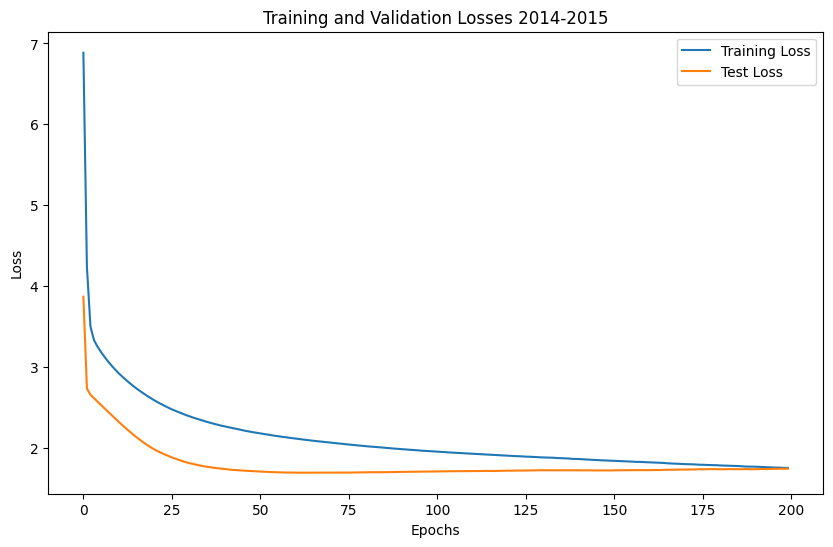

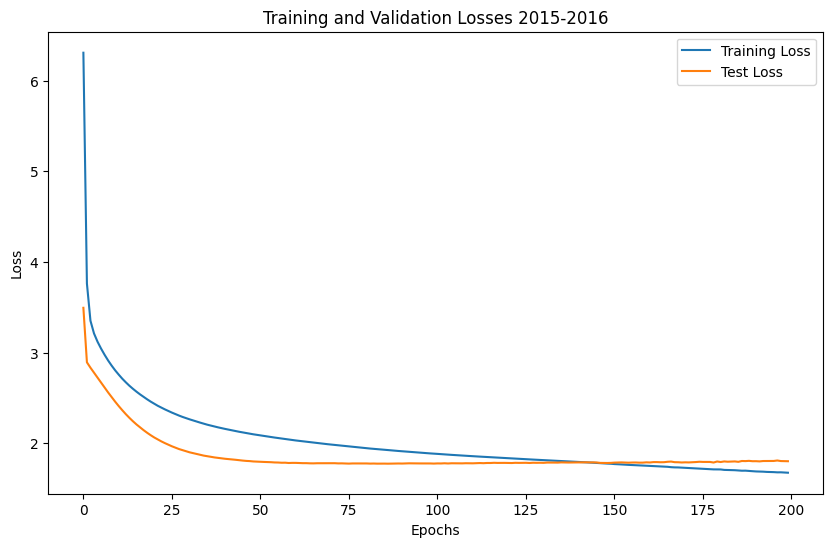

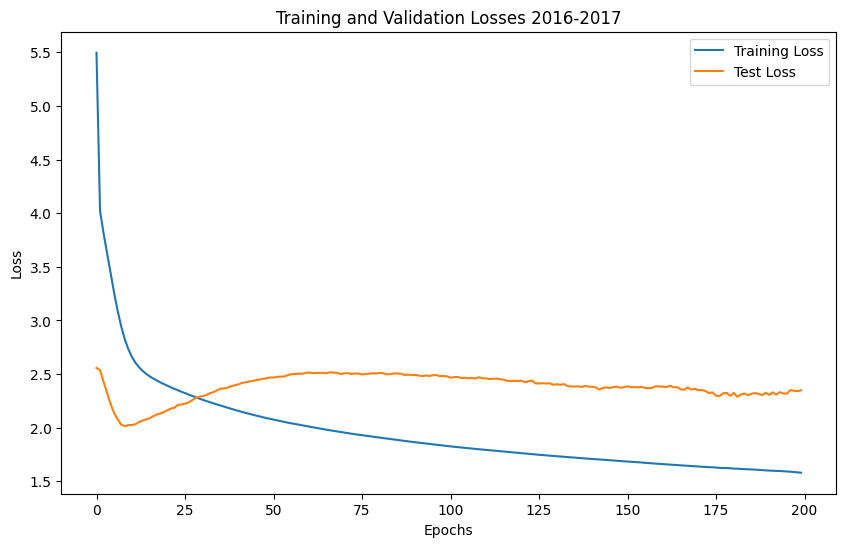

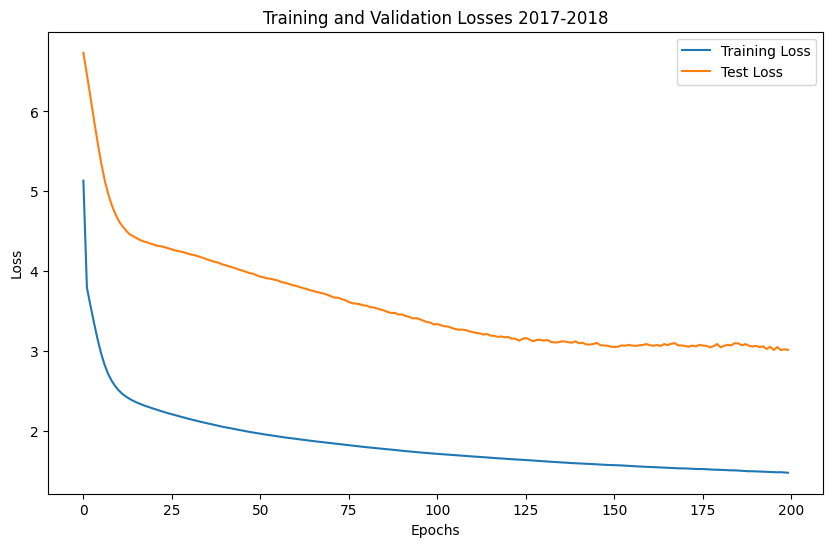

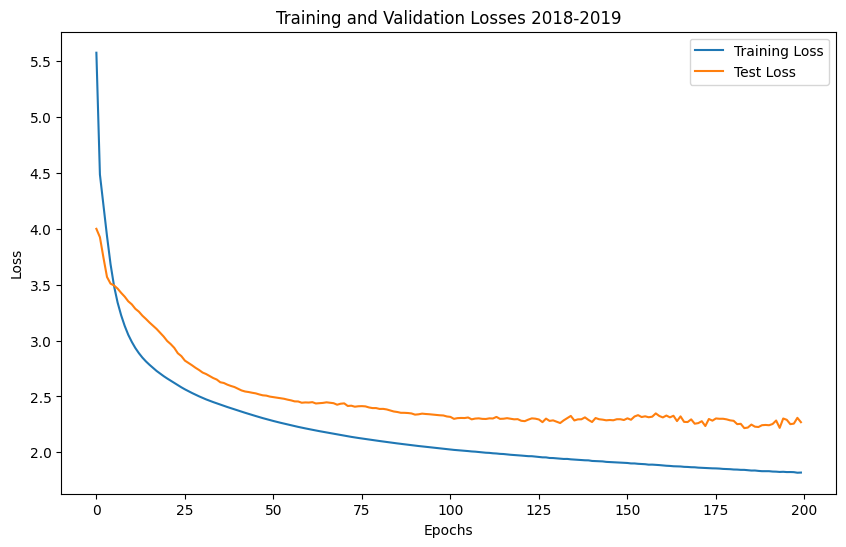

        Year      MAE          Pearson_Correlation               MAPE  \
                 mean      std                mean      std      mean   
0  2014-2015  1.74744  0.04397             0.90390  0.00419  25.95521   
1  2015-2016  1.85191  0.05549             0.91872  0.00474  23.37582   
2  2016-2017  2.38347  0.15816             0.90981  0.00896  55.48999   
3  2017-2018  3.10235  0.18096             0.94142  0.00647  28.41512   
4  2018-2019  2.33272  0.79953             0.91763  0.01371  55.20655   
5    Average  2.28358  0.17346             0.91824  0.00292  37.68854   

             
        std  
0   1.64442  
1   2.09841  
2   6.60281  
3   5.70305  
4  22.10254  
5   4.82380  


In [8]:
query_similarities = pd.read_csv('../fyp_data/average.csv').iloc[:1000]['Query'].to_list()
model_performance, model_predictions = run_neural_network(query_similarities, threshold=0.3)
model_performance.to_csv('../results/baseline_ffnn/forecasting_t+14_performance.csv', index=False)
model_predictions.to_csv('../results/baseline_ffnn/forecasting_t+14_predictions.csv', index=False)
print(model_performance)